In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris['data']
y = iris['target']

n_samples, n_features = X.shape

print('Number of Samples: ',n_samples)
print('Number of Features: ',n_features)

Number of Samples:  150
Number of Features:  4


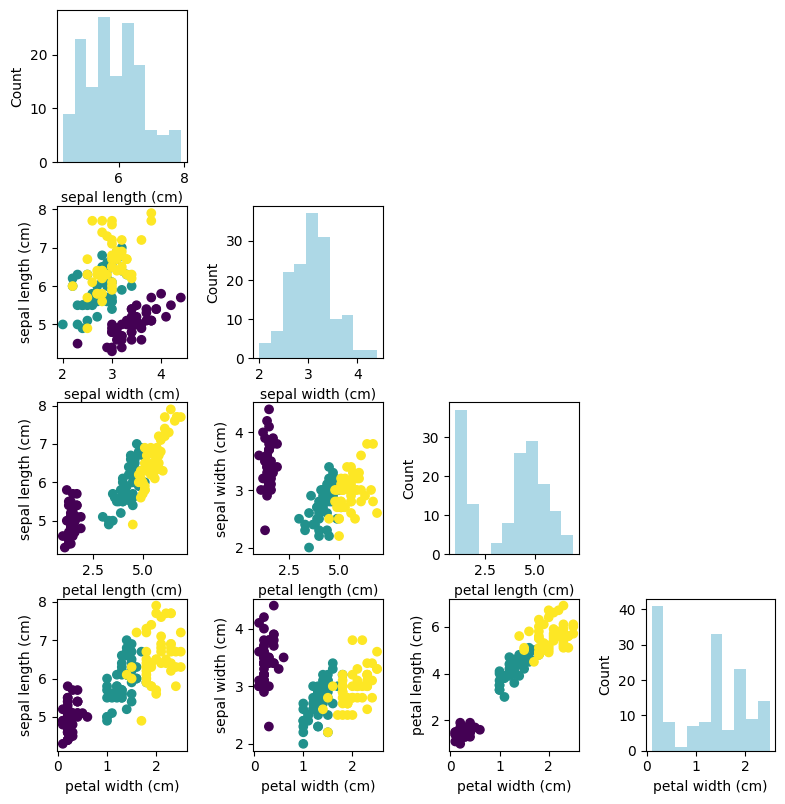

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize=(8,8))
fig.tight_layout()

names = iris.feature_names

for i,j in zip(*np.triu_indices_from(ax, k=1)):
    ax[j,i].scatter(X[:,j], X[:,i], c=y)
    ax[j,i].set_xlabel(names[j])
    ax[j,i].set_ylabel(names[i])
    ax[i,j].set_axis_off()
    
for i in range(n_features):
    ax[i,i].hist(X[:,i], color='lightblue')
    ax[i,i].set_ylabel('Count')
    ax[i,i].set_xlabel(names[i])

In [39]:
def mean(x): #np.mean(X, axis=0)
    return sum(x)/len(x)

def std(x): #np.std(X, axis=0)
    return (sum((i-mean(x))**2 for i in x)/len(x))**0.5

def Standardize_data(X):
    return (X-mean(X))/std(X)

X_std = Standardize_data(X)

In [40]:
def covariance(x):
    return (x.T@x)/(x.shape[0]-1)

cov_mat = covariance(X_std) #np.cov(X_std.T)

In [41]:
from numpy.linalg import eig

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_mat) 

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]


In [42]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the Lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x:x[0], reverse=True)

# for further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs)

[(2.9380850501999918, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])), (0.920164904162487, array([0.37741762, 0.92329566, 0.02449161, 0.06694199])), (0.14774182104494785, array([ 0.71956635, -0.24438178, -0.14212637, -0.63427274])), (0.020853862176462023, array([-0.26128628,  0.12350962,  0.80144925, -0.52359713]))]


In [43]:
#select top k eigenvectors
k = 2
W = eig_vecs_sorted[:k,:] #projection matrix
print(W.shape)

(2, 4)


Explained variance: [72.96 22.85  3.67  0.52]
Cumulative explained: [ 72.96  95.81  99.48 100.  ]


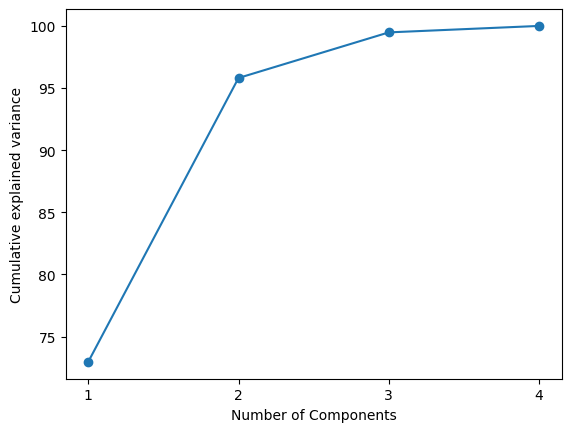

In [44]:
eig_vals_total = sum(eig_vals)
explained_variance = [(i/eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained: {}'.format(cum_explained_variance))

plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xticks(np.arange(1,n_features+1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [45]:
X_proj = X_std.dot(W.T)
print(X_proj.shape)

(150, 2)


Text(0.5, 1.0, '2 components, captures 95.81 of total variation')

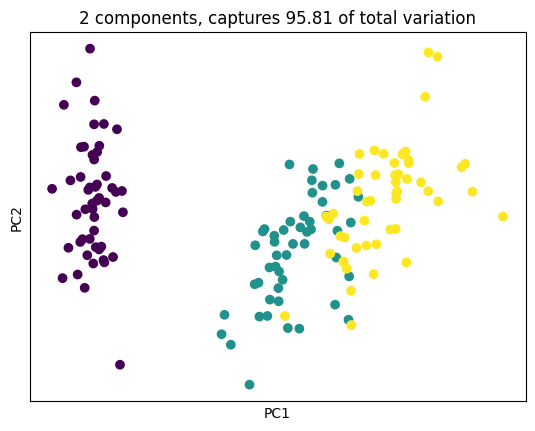

In [46]:
plt.scatter(X_proj[:,0], X_proj[:,1], c=y)
plt.xlabel('PC1');plt.xticks([])
plt.ylabel('PC2');plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))

In [49]:
class MyPCA:
    
    def __init__(self, n_components):
        self.n_components = n_components   
        
    def fit(self, X):
        # Standardize data 
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X_std = (X - self.mean) / self.scale
        
        # Eigendecomposition of covariance matrix       
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
        
        # Adjusting the eigenvectors that are largest in absolute value to be positive    
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs*signs[np.newaxis,:]
        eig_vecs = eig_vecs.T
       
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
        
        self.components = eig_vecs_sorted[:self.n_components,:]
        
        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]
        
        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)
        
        return X_proj
# ---------------------------------------------------------
my_pca = MyPCA(n_components = 2).fit(X)

print('Components:\n', my_pca.components)
print('Explained variance ratio from scratch:\n', my_pca.explained_variance_ratio)
print('Cumulative explained variance from scratch:\n', my_pca.cum_explained_variance)

X_proj = my_pca.transform(X)
print('Transformed data shape from scratch:', X_proj.shape)

Components:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance ratio from scratch:
 [0.7296244541329989, 0.22850761786701754]
Cumulative explained variance from scratch:
 [0.72962445 0.95813207]
Transformed data shape from scratch: (150, 2)


Components:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance ratio:
 [0.72962445 0.22850762]
Cumulative Explained variance:
 [0.72962445 0.95813207]
Transformed data shape: (150, 2)


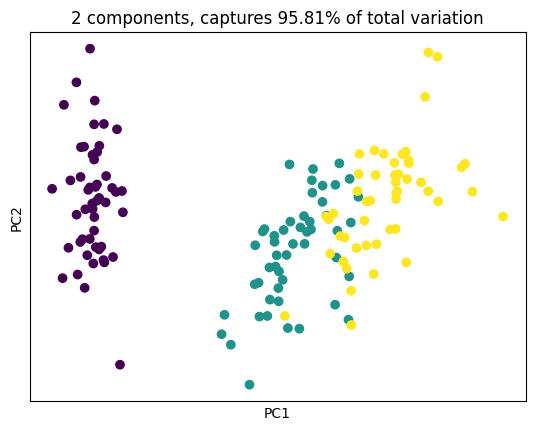

In [50]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_std)

print('Components:\n',pca.components_)
print('Explained variance ratio:\n',pca.explained_variance_ratio_)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative Explained variance:\n',cum_explained_variance)

X_pca = pca.transform(X_std) #applying dimensionality reduction to X
print('Transformed data shape:',X_pca.shape)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel('PC1');plt.xticks([])
plt.ylabel('PC2');plt.yticks([])

plt.title('2 components, captures {}% of total variation'.format(cum_explained_variance[1].round(4)*100))
plt.show()